In [ ]:
!cp -r /root/.cache/kagglehub/datasets/ikarus777/best-artworks-of-all-time/versions/1/images/images/ /content/drive/MyDrive/NST/style/

In [ ]:
!cp -r /root/.cache/kagglehub/datasets/starktony45/image-dataset/ /content/drive/MyDrive/NST/content/

cp: cannot stat '/root/.cache/kagglehub/datasets/starktony45/image-dataset/': No such file or directory


# Dataset Preparation & Preprocessing

In [1]:
import torch
import numpy as np
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [2]:
# import kagglehub

# # Download latest version
# style_path = kagglehub.dataset_download("ikarus777/best-artworks-of-all-time")

# print("Path to dataset files:", style_path)

In [3]:
import kagglehub

# # Download latest version
content_path = kagglehub.dataset_download("starktony45/image-dataset")
# content_path = kagglehub.dataset_download("bardiaardakanian/mmsample")


print("Path to dataset files:", content_path)

Path to dataset files: /kaggle/input/image-dataset


In [4]:
# style1_path = f"{style_path}/images/images/Pablo_Picasso"
# style2_path = f"{style_path}/images/images/Vincent_van_Gogh"
# style3_path = f"{style_path}/images/images/Edvard_Munch"
content1_path = f"{content_path}/train2014"

# print(style1_path)
print(content1_path)

/kaggle/input/image-dataset/train2014


In [5]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch

def get_transform(image_size=256, scale_to_255=False):
    transform_list = [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()   # Scales to float32 [0, 1]
    ]
    if scale_to_255:
        transform_list.append(transforms.Lambda(lambda x: x * 255))
    return transforms.Compose(transform_list)

class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_images=None):
        self.image_paths = [
            os.path.join(root_dir, f)
            for f in os.listdir(root_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]
        if max_images:
            self.image_paths = self.image_paths[:max_images]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

image_size = 256
batch_size = 4
# max_images = 2000
content_dir = "/kaggle/input/image-dataset/train2014"


transform = get_transform(image_size=image_size, scale_to_255=False)
dataset = ImageFolderDataset(content_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

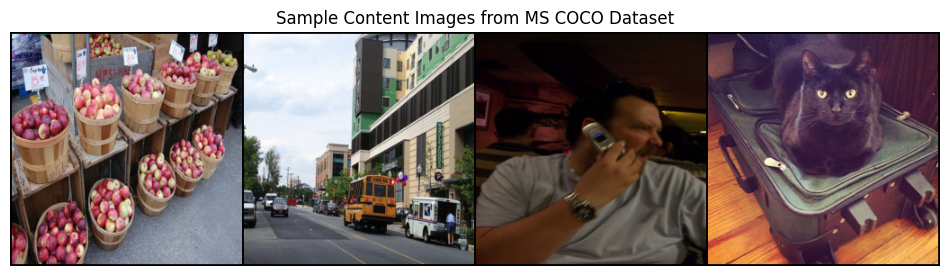

In [6]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_batch(batch_tensor, title="Batch of Images"):
    grid_img = vutils.make_grid(batch_tensor, nrow=4, padding=2, normalize=True)
    np_img = grid_img.permute(1, 2, 0).cpu().numpy()  # CHW -> HWC
    plt.figure(figsize=(12, 6))
    plt.imshow(np_img)
    plt.title(title)
    plt.axis('off')
    plt.show()

for batch in dataloader:
    show_batch(batch, title="Sample Content Images from MS COCO Dataset")
    break

# Transform Network Architecture

In [7]:
import torch
import torch.nn as nn

# Helper blocks
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, relu=True):
        super().__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.InstanceNorm2d(out_channels, affine=True)
        ]
        if relu:
            layers.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvLayer(channels, channels, kernel_size=3, stride=1, padding=1),
            ConvLayer(channels, channels, kernel_size=3, stride=1, padding=1, relu=False)
        )

    def forward(self, x):
        return x + self.block(x)

class UpsampleConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super().__init__()
        self.upsample = upsample
        self.conv = nn.Sequential(
            nn.Upsample(scale_factor=upsample, mode='nearest') if upsample else nn.Identity(),
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, kernel_size // 2),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

# Full Transform Net
class TransformerNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Initial layers
        self.initial = nn.Sequential(
            ConvLayer(3, 32, kernel_size=9, stride=1, padding=4),
            ConvLayer(32, 64, kernel_size=3, stride=2, padding=1),
            ConvLayer(64, 128, kernel_size=3, stride=2, padding=1)
        )

        # Residual blocks
        self.residuals = nn.Sequential(
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128)
        )

        # Upsampling
        self.upsample = nn.Sequential(
            UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2),
            UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2),
            nn.Conv2d(32, 3, kernel_size=9, stride=1, padding=4),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.residuals(x)
        x = self.upsample(x)
        return x


# Perceptual Loss using VGG16

In [8]:
from torchvision.models import vgg19, VGG19_Weights
import torch.nn.functional as F

# Define which layers to use
CONTENT_LAYER = 'relu2_2'
STYLE_LAYERS = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3']

import torch
import torch.nn as nn
from torchvision.models import vgg16, VGG16_Weights

class VGG16Features(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = vgg16(weights=VGG16_Weights.DEFAULT).features

        # Slices for each block/layer
        self.slice1 = nn.Sequential(*vgg[:4])   # relu1_2
        self.slice2 = nn.Sequential(*vgg[4:9])  # relu2_2
        self.slice3 = nn.Sequential(*vgg[9:16]) # relu3_3
        self.slice4 = nn.Sequential(*vgg[16:23])# relu4_3

        # Freeze VGG params
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.slice1(x)
        relu1_2 = h
        h = self.slice2(h)
        relu2_2 = h
        h = self.slice3(h)
        relu3_3 = h
        h = self.slice4(h)
        relu4_3 = h
        return {
            'relu1_2': relu1_2,
            'relu2_2': relu2_2,
            'relu3_3': relu3_3,
            'relu4_3': relu4_3
        }

def gram_matrix(feat):
    b, c, h, w = feat.size()
    f = feat.view(b, c, h * w)
    return torch.bmm(f, f.transpose(1, 2)) / (c * h * w)


In [9]:
import torch
import torch.nn as nn

class PerceptualLoss(nn.Module):
    def __init__(self, content_weight=1.0, style_weight=5e2):
        super().__init__()
        self.vgg = VGG16Features()
        self.content_weight = content_weight
        self.style_weight = style_weight
        self.criterion = nn.MSELoss()

        # Layer names (must match those used in VGG16Features)
        self.content_layer = CONTENT_LAYER
        self.style_layers = STYLE_LAYERS

    def forward(self, input_img, content_img, style_img):
        # Extract features
        input_feats = self.vgg(input_img)
        content_feats = self.vgg(content_img)
        style_feats = self.vgg(style_img)

        # --- Content loss ---
        content_loss = self.criterion(input_feats[self.content_layer], content_feats[self.content_layer])

        # --- Style loss ---
        style_loss = 0.0
        for layer in self.style_layers:
            gram_input = gram_matrix(input_feats[layer])
            gram_target = gram_matrix(style_feats[layer])
            style_loss += self.criterion(gram_input, gram_target)

        # --- Total loss ---
        total_loss = self.content_weight * content_loss + self.style_weight * style_loss
        return total_loss, content_loss, style_loss

In [10]:
# imagenet_mean = [0.485, 0.456, 0.406]
# imagenet_std = [0.229, 0.224, 0.225]

# vgg_normalize = transforms.Normalize(mean=imagenet_mean, std=imagenet_std)

# def preprocess_for_vgg(batch):
#     batch = (batch + 1) / 2  # [-1,1] -> [0,1]
#     return vgg_normalize(batch)

IMAGENET_MEAN_1 = np.array([0.485, 0.456, 0.406])
IMAGENET_STD_1 = np.array([0.229, 0.224, 0.225])
IMAGENET_MEAN_255 = np.array([123.675, 116.28, 103.53])
# Usually when normalizing 0..255 images only mean-normalization is performed -> that's why standard dev is all 1s here
IMAGENET_STD_NEUTRAL = np.array([1, 1, 1])

# Training

In [14]:
training_config = {
    'image_size': 256,
    'batch_size': 4,
    'num_epochs': 2,
    'log_interval': 50,
    'style_image_path': '/content/drive/MyDrive/nst/style-images/stary_night.jpg'
}

In [15]:
from PIL import Image
from torchvision import transforms
import torch

def load_style_image(image_path, image_size=256, device='cuda'):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),  # Scales to [0, 1]
    ])

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)  # Shape: [1, 3, H, W]
    return image_tensor


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


def train(training_config, log_interval=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transformer_net = TransformerNet().to(device)
    perceptual_loss = PerceptualLoss(style_weight=5e5).to(device)

    optimizer = optim.Adam(transformer_net.parameters(), lr=1e-3)

    style_image = load_style_image(training_config['style_image_path'], image_size=training_config['image_size'], device=device)
    style_batch = style_image.repeat(batch_size, 1, 1, 1)

    transformer_net.train()
    for epoch in range(training_config['num_epochs']):
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{training_config['num_epochs']}")
        for batch_idx, content_batch in enumerate(pbar):
            content_batch = content_batch.to(device)

            if content_batch.size(0) != style_batch.size(0):
                style_batch = style_image.repeat(content_batch.size(0), 1, 1, 1)

            optimizer.zero_grad()
            output = transformer_net(content_batch)

            loss, content_loss, style_loss = perceptual_loss(output, content_batch, style_batch)

            loss.backward()
            optimizer.step()

            if batch_idx % log_interval == 0:
                pbar.set_postfix({
                    "Total Loss": f"{loss.item():.2f}",
                    "Content": f"{content_loss.item():.2f}",
                    "Style": f"{style_loss.item():.2f}"
                })

    # TODO: Save model state

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transformer_net = TransformerNet().to(device)
perceptual_loss = PerceptualLoss(style_weight=5e5).to(device)

optimizer = optim.Adam(transformer_net.parameters(), lr=1e-3)

style_img_path = training_config['style_image_path']
style_image = load_style_image(style_img_path, image_size=256, device=device)

style_batch = style_image.repeat(batch_size, 1, 1, 1)

num_epochs = 1
log_interval = 50

transformer_net.train()
for epoch in range(num_epochs):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch_idx, content_batch in enumerate(pbar):
        content_batch = content_batch.to(device)

        if content_batch.size(0) != style_batch.size(0):
            style_batch = style_image.repeat(content_batch.size(0), 1, 1, 1)

        optimizer.zero_grad()
        output = transformer_net(content_batch)

        loss, content_loss, style_loss = perceptual_loss(output, content_batch, style_batch)

        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            pbar.set_postfix({
                "Total Loss": f"{loss.item():.2f}",
                "Content": f"{content_loss.item():.2f}",
                "Style": f"{style_loss.item():.2f}"
            })

Epoch 1/1: 100%|██████████| 20696/20696 [22:51<00:00, 15.09it/s, Total Loss=0.76, Content=0.55, Style=0.00]


In [17]:
model_path = "fast_style_model.pth"
torch.save(transformer_net.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to fast_style_model.pth


# Inference

In [ ]:
# Load the saved model

In [20]:
def stylize_image(model, input_image_path, output_image_path):
    model.eval()
    image = Image.open(input_image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image).cpu().squeeze(0)
        output = output * 0.5 + 0.5  # unnormalize
        output_image = transforms.ToPILImage()(output.clamp(0, 1))
        output_image.save(output_image_path)
        print(f"Saved stylized image to {output_image_path}")


input_image_path_1 = '/content/drive/MyDrive/nst/content-images/lion.jpg'
input_image_path_2 = '/content/drive/MyDrive/nst/content-images/dog.jpg'
input_image_path_3 = '/content/drive/MyDrive/nst/content-images/ortakoy_istanbul.jpg'

output_image_path = '/content/stylized_output.jpg'

stylize_image(transformer_net, input_image_path_3, output_image_path)

Saved stylized image to /content/stylized_output.jpg


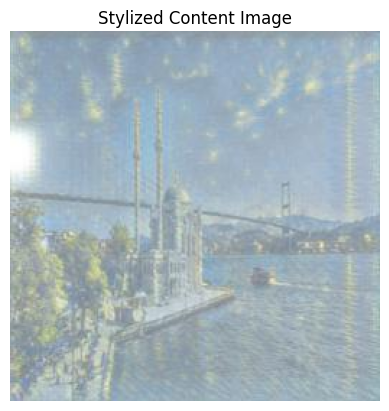

In [21]:
from PIL import Image
from torchvision import transforms

def load_image(path, max_size=512, shape=None):
    image = Image.open(path).convert('RGB')

    # Resize
    if max_size:
        size = min(max(image.size), max_size)
        transform = transforms.Resize(size)
        image = transform(image)

    if shape:
        transform = transforms.Resize(shape)
        image = transform(image)

    # Transform to tensor
    transform = transforms.ToTensor()
    image = transform(image).unsqueeze(0)  # Add batch dimension

    return image

import matplotlib.pyplot as plt
import torch

def imshow(tensor, title=None):
    image = tensor.clone().detach().cpu().squeeze(0)  # remove batch dimension
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

image = load_image(output_image_path)
imshow(image, title="Stylized Content Image")

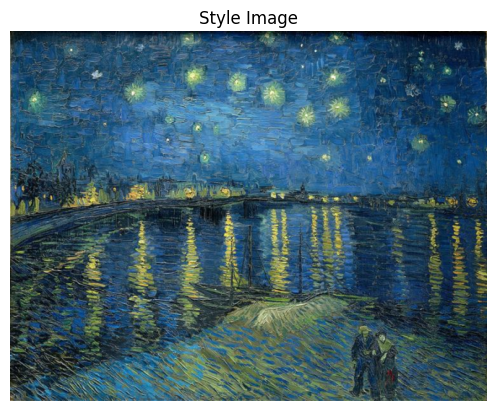

In [22]:
image = load_image(style_img_path).to(device)

imshow(image, title="Style Image")